In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 21 14:33:09 2016

@author: tachukao
"""

import numpy as np
#import matplotlib.pyplot as plt
from numpy import linalg as npLA
from scipy import linalg as spLA

def SOC(num_neurons,p,R):
    C = 1.5 # numerical constant
    gamma = 3
    n = 10 #learning rate
    first_quadrant = np.arange(num_neurons/2).astype(int)
    second_quadrant = (first_quadrant + num_neurons/2).astype(int)
    
    
    W = np.zeros((num_neurons,num_neurons))
    w0 =  R / np.sqrt(p * (1-p) * (1 + gamma**2) /2)
    for i in np.arange(num_neurons):
        for j in np.arange(num_neurons):
            if i != j:
                if np.random.rand() < p and j <= num_neurons/2:
                    W[i,j] = w0 / np.sqrt(num_neurons)
                elif np.random.rand() < p and j > num_neurons/2:
                    W[i,j] = - gamma * w0 / np.sqrt(num_neurons)
        
    W_adj = np.zeros((num_neurons,num_neurons))
    W_adj[W.nonzero()] = 1
    A = np.random.rand(num_neurons,num_neurons)
    A[A < 0.35] = -1
    A[A >= 0.35] = 0
    A[A < 0] = 1
    A = A - np.diag(np.diag(A))
    W_adj = W_adj + A - W_adj * A
    
    
    alpha = max(np.real(npLA.eig(W)[0]))
    s = max(C * alpha,alpha+0.2)
    Q = spLA.solve_lyapunov(np.transpose(W - s * np.eye(num_neurons)), - 2 * np.eye(num_neurons))
    i = 0
#    plt.figure()
#    plt.isinteractive = False
    step = 0
#    e = 1 / np. trace(Q)
    while alpha >= 0.2:
        # solve Lyapunov equation
        step = step + 1
        if np.mod(step,500) == 0:
            print("number of steps: ", step, " alpha:", alpha)
        
        P = spLA.solve_lyapunov(W - s * np.eye(num_neurons), - 2 * np.eye(num_neurons))
        deltaW = n * np.dot(Q,P) / np.trace(np.dot(Q,P))
        deltaW[:,first_quadrant] = 0
        W = W - deltaW
        
        # clipping positive inhibition neurons to zero
        W_i = W[:,second_quadrant]
        W_i[W_i>0] = 0
        W = np.hstack((W[:,first_quadrant],W_i))
        
    #    # impost relative inhibitory strength constraint
        W_EE = W[np.ix_(first_quadrant,first_quadrant)]
        W_EI = W[np.ix_(first_quadrant,second_quadrant)]
        W_IE = W[np.ix_(second_quadrant,first_quadrant)]
        W_II = W[np.ix_(second_quadrant,second_quadrant)]    
        W_EI = - gamma * W_EI * np.mean(W_EE) / np.mean(W_EI)
        W_II = - gamma * W_II * np.mean(W_IE) / np.mean(W_II)
        W = np.vstack((np.hstack((W_EE,W_EI)),np.hstack((W_IE,W_II))))
        
        # impose density constraints
        W[W_adj ==0] = 0
        
#        i = i + 1
#        if np.mod(i,20) == 0:
#            plt.clf()
#            plt.axis([-5, 5, -5 ,5]) 
#            plt.plot(npLA.eig(W)[0].real,npLA.eig(W)[0].imag,'ro')
#            plt.ion()        
#            plt.draw()        
#            plt.pause(0.01)
             
            
        alpha = max(np.real(npLA.eig(W)[0]))
        s = max(C * alpha,alpha + 0.2)
        Q = spLA.solve_lyapunov(np.transpose(W - s * np.eye(num_neurons)), - 2 * np.eye(num_neurons))
#        e = 1 / np.trace(Q)
    a_l = npLA.eig(Q)[1][:,np.argmax(npLA.eig(Q)[0])]
    a_r = npLA.eig(Q)[1][:,np.argsort(npLA.eig(Q)[0])[-2]]
    return W,a_l,a_r, alpha




In [2]:
W=SOC(200,0.1,5)

number of steps:  500  alpha: 0.45556705485428806
number of steps:  1000  alpha: 0.2921115686631137
number of steps:  1500  alpha: 0.24918352147095496
number of steps:  2000  alpha: 0.22334385429938483
number of steps:  2500  alpha: 0.21332389275635283
number of steps:  3000  alpha: 0.2087611544587682
number of steps:  3500  alpha: 0.20396929994638957


In [6]:
np.save('W.npy',W[0])

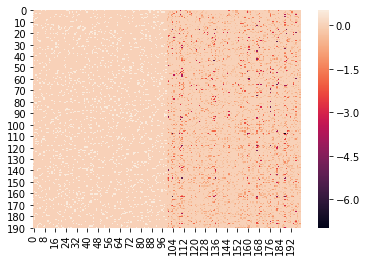

In [10]:
#print(W[0].shape)
import seaborn as sns
sns.heatmap(W[0])